### Imports and Set-up


In [1]:
import os
import shutil
import random
import cv2
from tqdm import tqdm
import imutils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Constants
SEED = 2203322

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Set up paths
base_dir = '../../dataset_26'
data_dir = './preprocessed_data/train_validation_data'
train_dir = './preprocessed_data/train'
validation_dir = './preprocessed_data/validation'

# # Create train and validation directories
# os.makedirs(data_dir, exist_ok=True)
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(validation_dir, exist_ok=True)

['glioma', 'meningioma', 'notumor', 'pituitary']


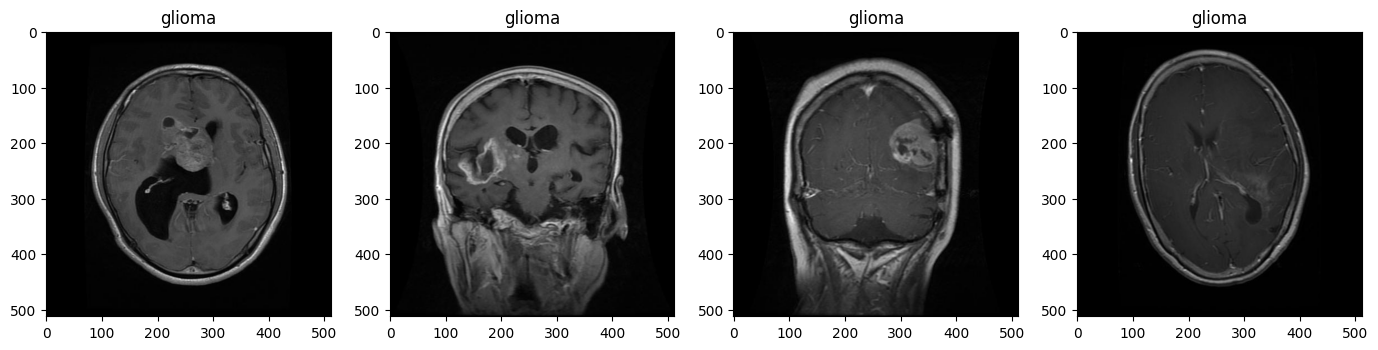

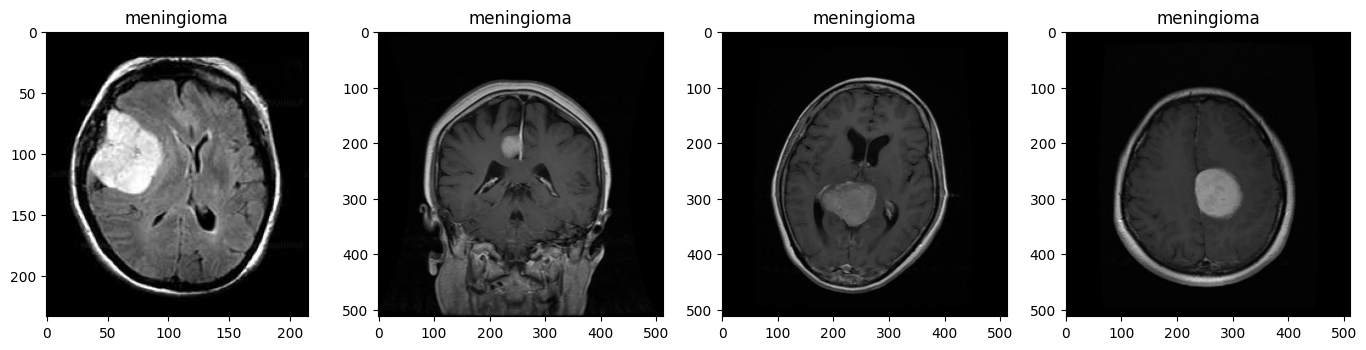

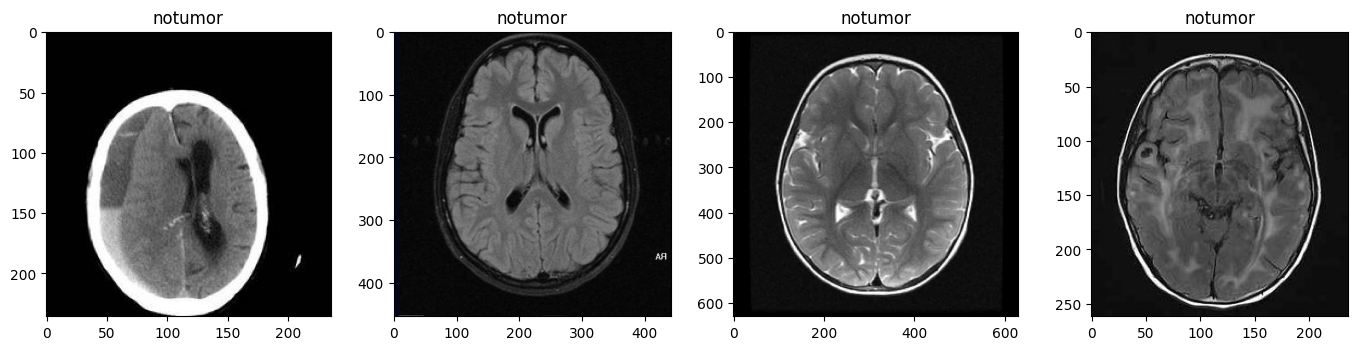

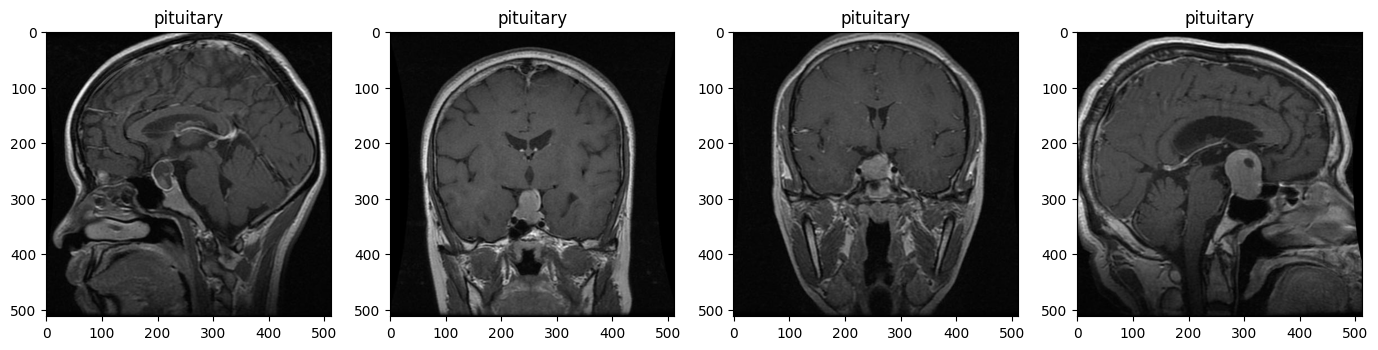

In [2]:
classes = os.listdir(base_dir)
print(classes)

for cls in classes:
  os.makedirs(f'{data_dir}/{cls}', exist_ok=True)
  os.makedirs(f'{train_dir}/{cls}', exist_ok=True)
  os.makedirs(f'{validation_dir}/{cls}', exist_ok=True)

base_image_paths = {cls: list(map(lambda x: os.path.join(base_dir, cls, x), os.listdir(os.path.join(base_dir, cls)))) for cls in classes}
base_image_paths

for cls in classes:
  plt.figure(figsize=(17, 17))
  random.shuffle(base_image_paths[cls])
  files = base_image_paths[cls][:5]

  for i in range(1, 5):
    plt.subplot(4, 4, i)
    plt.imshow(load_img(files[i]))
    plt.title(cls)

### Data Preprocessing and Preparation

Functions

In [3]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]      

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

def crop_img_saver(class_read_paths, save_dir):
  for cls in class_read_paths:
    for i, p in tqdm(enumerate(os.listdir(cls))):
      path = os.path.join(cls, p)
      img = crop_image(cv2.imread(path), plot=False)

      if img is not None:
        img = cv2.resize(img, (224, 224))
        save_class = cls.split('\\')[-1]
        save_path = os.path.join(save_dir, save_class, f'{str(i)}.jpg')
        cv2.imwrite(save_path, img)

# crop_image(cv2.imread(data_files_path['notumor'][14]), True)

Crop and Shift into folders

In [4]:
base_class_paths = [os.path.join(base_dir, cls) for cls in classes]
crop_img_saver(base_class_paths, save_dir=data_dir)

unprocessed_test_dir = './unprocessed_test'
unprocessed_test_class_paths = [os.path.join(unprocessed_test_dir, cls) for cls in classes]
test_dir = './preprocessed_data/test'
for cls in classes:
  os.makedirs(f'{test_dir}/{cls}', exist_ok=True)
# Crop test data
crop_img_saver(unprocessed_test_class_paths, save_dir=test_dir)

# # Iterate through each class folder and split data
# for folder in os.listdir(data_dir):
#     folder_path = os.path.join(data_dir, folder)
    
#     if os.path.isdir(folder_path):
#         # Create class directories in train and validation folders
#         train_class_dir = os.path.join(train_dir, folder)
#         validation_class_dir = os.path.join(validation_dir, folder)
#         os.makedirs(train_class_dir, exist_ok=True)
#         os.makedirs(validation_class_dir, exist_ok=True)

#         # Split data into train and validation sets
#         images = os.listdir(folder_path)
#         labels = [folder] * len(images)
#         train_images, validation_images, train_labels, validation_labels = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=SEED)

#         # Copy images to train and validation folders
#         for image in train_images:
#             shutil.copy(os.path.join(folder_path, image), os.path.join(train_class_dir, image))
#         for image in validation_images:
#             shutil.copy(os.path.join(folder_path, image), os.path.join(validation_class_dir, image))

120it [00:00, 324.89it/s]
120it [00:00, 307.14it/s]
120it [00:00, 333.90it/s]
120it [00:00, 188.14it/s]
120it [00:00, 133.66it/s]
120it [00:00, 263.59it/s]
120it [00:00, 181.56it/s]
120it [00:00, 248.34it/s]


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


c:\Users\Frederick Ang\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


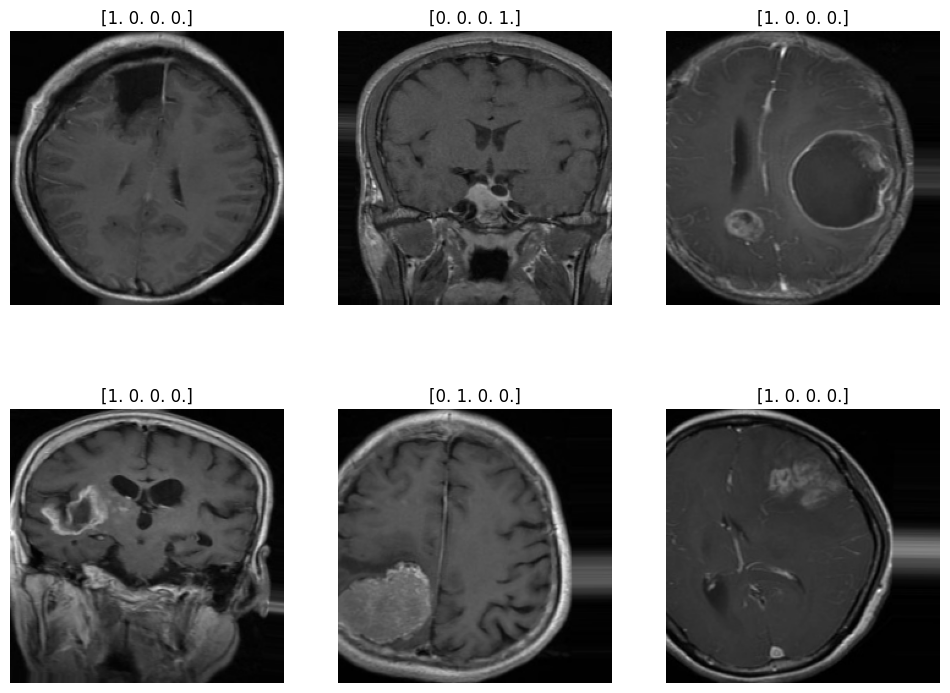

In [5]:
# train_data_generator = ImageDataGenerator(rescale=1./255,
#                                           rotation_range=10, 
#                                           height_shift_range=0.2, 
#                                           horizontal_flip=True)

# train_data = train_data_generator.flow_from_directory(train_dir,
#                                                       target_size=(224, 224),
#                                                       batch_size=16,
#                                                       class_mode='categorical')

# validation_data_generator = ImageDataGenerator(rotation_range=10, 
#                                           height_shift_range=0.2, 
#                                           horizontal_flip=True)

# validation_data = validation_data_generator.flow_from_directory(validation_dir,
#                                                       target_size=(224, 224),
#                                                       batch_size=32,
#                                                       class_mode='categorical')

train_data_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=10, 
                                          height_shift_range=0.2, 
                                          horizontal_flip=True,
                                          validation_split=0.2)

train_data = train_data_generator.flow_from_directory(data_dir,
                                                      target_size=(224, 224),
                                                      batch_size=8,
                                                      class_mode='categorical',
                                                      subset='training')

validation_data = train_data_generator.flow_from_directory(data_dir,
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      subset='validation')

sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.axis('off'), plt.grid(False)
  # sample_img = array_to_img(sample_x[i])
  plt.imshow(array_to_img(sample_x[i]))
  plt.title(sample_y[i])

Adding Test data thats not in the dataset

In [6]:
# # Define paths to main folders A, B, and C
# transfer_folder = './Testing'
# compared_folder = '../../dataset_26'
# destination_folder = './unprocessed_test'

# # Ensure folders C and its subfolders exist
# os.makedirs(destination_folder, exist_ok=True)
# for subfolder in ['glioma', 'meningioma', 'notumor', 'pituitary']:
#     os.makedirs(os.path.join(destination_folder, subfolder), exist_ok=True)

# # Iterate through each subfolder
# subfolders = ['glioma', 'meningioma', 'notumor', 'pituitary']
# for subfolder in subfolders:
#     subfolder_transfer = os.path.join(transfer_folder, subfolder)
#     subfolder_compared = os.path.join(compared_folder, subfolder)
#     subfolder_destination = os.path.join(destination_folder, subfolder)

#     # Get lists of files in subfolders A and B
#     files_transfer = os.listdir(subfolder_transfer)
#     files_compared = os.listdir(subfolder_compared)

#     # Identify non-duplicate files in subfolder A (not present in subfolder B)
#     non_duplicate_files = [file for file in files_transfer if file not in files_compared]

#     # Shuffle non-duplicate files and select up to 120
#     random.shuffle(non_duplicate_files)
#     files_to_transfer = non_duplicate_files[:120]

#     # Transfer files from subfolder A to subfolder C
#     for file in files_to_transfer:
#         source_path = os.path.join(subfolder_transfer, file)
#         destination_path = os.path.join(subfolder_destination, file)
#         shutil.copyfile(source_path, destination_path)
#         print(f"Copied {file} from {subfolder_transfer} to {subfolder_destination}.")

# print("Transfer complete.")

### Load VGG-16 Model and Set-up
Load VGG-16 model and set up for extracting features

In [7]:
# Load the VGG16 model without the top layers
vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model as we have small dataset
for layer in vgg16_base.layers:
    layer.trainable = False

### Set-Up Fitting Callbacks

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='auto',
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_ckpt.model.keras', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='auto',
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=2, 
    min_lr=0.000001,
    verbose=1
)

### Feature Extraction and Classification Training

1. 

In [9]:
# Layers
model = Sequential()
model.add(vgg16_base)
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_data,
    validation_data=validation_data,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    epochs=20
)

model.summary()

Epoch 1/20


c:\Users\Frederick Ang\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.4280 - loss: 1.4957
Epoch 1: val_accuracy improved from -inf to 0.38542, saving model to model_ckpt.model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4321 - loss: 1.4870 - val_accuracy: 0.3854 - val_loss: 1.2028 - learning_rate: 1.0000e-04
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.7917 - loss: 0.6272
Epoch 2: val_accuracy improved from 0.38542 to 0.66667, saving model to model_ckpt.model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7903 - loss: 0.6289 - val_accuracy: 0.6667 - val_loss: 1.0273 - learning_rate: 1.0000e-04
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.7876 - loss: 0.6090
Epoch 3: val_accuracy improved from 0.66667 to 0.70833, saving model to model_ckpt.model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7876 - loss: 0.6078 - val_accuracy: 0.7083 - val_loss: 0.9463 - learning_rate: 1.0000e-04
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,197,326 (84.68 MB)

 Trainable params: 2,493,700 (9.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

 Optimizer params: 4,987,402 (19.03 MB)

2. 

In [12]:
# Layers
model = Sequential()
model.add(vgg16_base)
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 4 classes for classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history2 = model.fit(
    train_data,
    validation_data=validation_data,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    epochs=20
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3213 - loss: 2.1073
Epoch 1: val_accuracy did not improve from 0.76042
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3224 - loss: 2.1006 - val_accuracy: 0.3958 - val_loss: 1.2502 - learning_rate: 1.0000e-04
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4539 - loss: 1.7162
Epoch 2: val_accuracy did not improve from 0.76042
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4541 - loss: 1.7156 - val_accuracy: 0.4688 - val_loss: 1.1601 - learning_rate: 1.0000e-04
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4994 - loss: 1.4388
Epoch 3: val_accuracy did not improve from 0.76042
24/24 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5007 - loss: 1.4361 - val_accuracy: 0.5521 - val_loss: 1.0115 - learning_rate: 1.0000e-04
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6317 - loss: 1.2679
Epoch 4: val_accuracy did not improve from 0.76042
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/s

### Evaluation

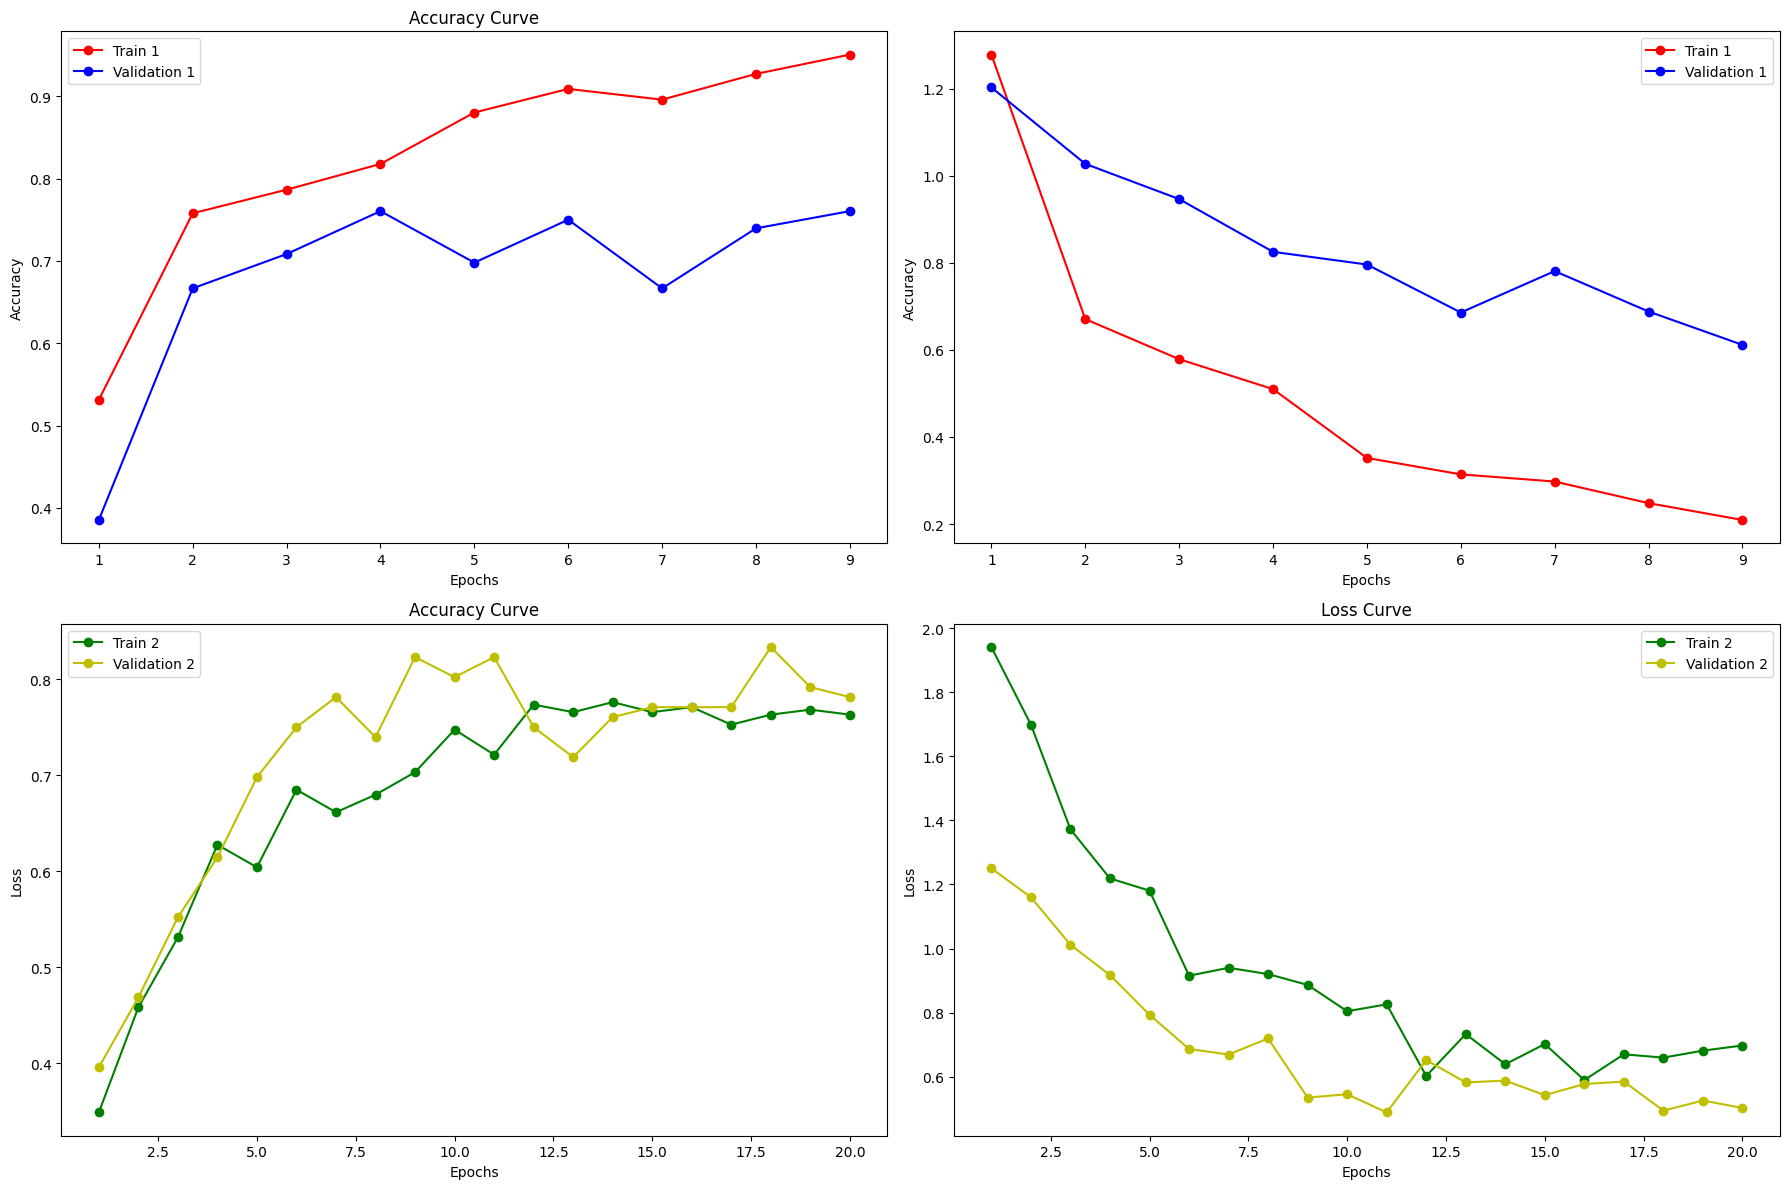

In [15]:
# # Evaluate the model
# train_loss, train_accuracy = model.evaluate(train_generator)
# validation_loss, validation_accuracy = model.evaluate(validation_generator)
# print(f'Training loss: {train_loss}')
# print(f'Training accuracy: {train_accuracy}')
# print(f'Validation loss: {validation_loss}')
# print(f'Validation accuracy: {validation_accuracy}')

# plt.style.use('ggplot')
# figure = plt.figure(figsize=(18, 6))
# epochs = range(1, 11)

# plt.subplot(121)
# plt.plot(epochs, history.history['accuracy'], 'ro-')
# plt.plot(epochs, history.history['val_accuracy'], 'bo-')
# plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy Curve')

# plt.subplot(122)
# plt.plot(epochs, history.history['loss'], 'ro-')
# plt.plot(epochs, history.history['val_loss'], 'bo-')
# plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss Curve')

# figure.legend(['Train', 'Validation'])

#

# def plot_hist(hist):
#     plt.plot(hist.history["accuracy"])
#     plt.plot(hist.history["val_accuracy"])
#     plt.title("model accuracy")
#     plt.ylabel("accuracy")
#     plt.xlabel("epoch")
#     plt.legend(["train", "validation"], loc="upper left")
#     plt.show()


# plot_hist(history)

# plt.style.use('ggplot')
figure, axes = plt.subplots(2, 2, figsize=(18, 12))
epochs = range(1, len(history.history['accuracy']) + 1)

# Plotting Accuracy
axes[0, 0].plot(epochs, history.history['accuracy'], 'ro-', label='Train 1')
axes[0, 0].plot(epochs, history.history['val_accuracy'], 'bo-', label='Validation 1')
axes[0, 0].set_xlabel('Epochs'), axes[0, 0].set_ylabel('Accuracy'), axes[0, 0].set_title('Accuracy Curve')
axes[0, 0].legend()

# Plotting Loss
axes[0, 1].plot(epochs, history.history['loss'], 'ro-', label='Train 1')
axes[0, 1].plot(epochs, history.history['val_loss'], 'bo-', label='Validation 1')
axes[0, 1].set_xlabel('Epochs'), axes[1, 0].set_ylabel('Loss'), axes[1, 0].set_title('Loss Curve')
axes[0, 1].legend()

epochs = range(1, len(history2.history['accuracy']) + 1)

if 'history2' in locals():
    axes[1, 0].plot(epochs, history2.history['accuracy'], 'go-', label='Train 2')
    axes[1, 0].plot(epochs, history2.history['val_accuracy'], 'yo-', label='Validation 2')
    axes[1, 0].set_xlabel('Epochs'), axes[0, 1].set_ylabel('Accuracy'), axes[1, 0].set_title('Accuracy Curve')
    axes[1, 0].legend()

if 'history2' in locals():
    axes[1, 1].plot(epochs, history2.history['loss'], 'go-', label='Train 2')
    axes[1, 1].plot(epochs, history2.history['val_loss'], 'yo-', label='Validation 2')
    axes[1, 1].set_xlabel('Epochs'), axes[1, 1].set_ylabel('Loss'), axes[1, 1].set_title('Loss Curve')
    axes[1, 1].legend()

# if 'history3' in locals():
#     axes[2, 0].plot(epochs, history3.history['accuracy'], 'co-', label='Train 3')
#     axes[2, 0].plot(epochs, history3.history['val_accuracy'], 'mo-', label='Validation 3')
#     axes[2, 0].set_xlabel('Epochs'), axes[1, 1].set_ylabel('Accuracy'), axes[2, 0].set_title('Accuracy Curve')
#     axes[2, 0].legend()

# if 'history4' in locals():
#     axes[3, 0].plot(epochs, history4.history['accuracy'], 'ko-', label='Train 4')
#     axes[3, 0].plot(epochs, history4.history['val_accuracy'], 'co-', label='Validation 4')
#     axes[3, 0].set_xlabel('Epochs'), axes[2, 0].set_ylabel('Accuracy'), axes[3, 0].set_title('Accuracy Curve')
#     axes[3, 0].legend()

# if 'history5' in locals():
#     axes[4, 0].plot(epochs, history5.history['accuracy'], 'mo-', label='Train 5')
#     axes[4, 0].plot(epochs, history5.history['val_accuracy'], 'yo-', label='Validation 5')
#     axes[4, 0].set_xlabel('Epochs'), axes[2, 1].set_ylabel('Accuracy'), axes[4, 0].set_title('Accuracy Curve')
#     axes[4, 0].legend()

# if 'history6' in locals():
#     axes[5, 0].plot(epochs, history6.history['accuracy'], 'co-', label='Train 6')
#     axes[5, 0].plot(epochs, history6.history['val_accuracy'], 'ko-', label='Validation 6')
#     axes[5, 0].set_xlabel('Epochs'), axes[3, 0].set_ylabel('Accuracy'), axes[5, 0].set_title('Accuracy Curve')
#     axes[5, 0].legend()

# if 'history7' in locals():
#     axes[6, 0].plot(epochs, history7.history['accuracy'], 'ro-', label='Train 7')
#     axes[6, 0].plot(epochs, history7.history['val_accuracy'], 'bo-', label='Validation 7')
#     axes[6, 0].set_xlabel('Epochs'), axes[3, 1].set_ylabel('Accuracy'), axes[6, 0].set_title('Accuracy Curve')
#     axes[6, 0].legend()

# if 'history8' in locals():
#     axes[7, 0].plot(epochs, history8.history['accuracy'], 'go-', label='Train 8')
#     axes[7, 0].plot(epochs, history8.history['val_accuracy'], 'yo-', label='Validation 8')
#     axes[7, 0].set_xlabel('Epochs'), axes[3, 1].set_ylabel('Accuracy'), axes[7, 0].set_title('Accuracy Curve')
#     axes[7, 0].legend()

# if 'history9' in locals():
#     axes[8, 0].plot(epochs, history9.history['accuracy'], 'ro-', label='Train 9')
#     axes[8, 0].plot(epochs, history9.history['val_accuracy'], 'bo-', label='Validation 9')
#     axes[8, 0].set_xlabel('Epochs'), axes[3, 1].set_ylabel('Accuracy'), axes[8, 0].set_title('Accuracy Curve')
#     axes[8, 0].legend()




# if 'history3' in locals():
#     axes[2, 1].plot(epochs, history3.history['loss'], 'co-', label='Train 3')
#     axes[2, 1].plot(epochs, history3.history['val_loss'], 'mo-', label='Validation 3')
#     axes[2, 1].set_xlabel('Epochs'), axes[2, 0].set_ylabel('Loss'), axes[2, 1].set_title('Loss Curve')
#     axes[2, 1].legend()

# if 'history4' in locals():
#     axes[3, 1].plot(epochs, history4.history['loss'], 'ko-', label='Train 4')
#     axes[3, 1].plot(epochs, history4.history['val_loss'], 'co-', label='Validation 4')
#     axes[3, 1].set_xlabel('Epochs'), axes[2, 1].set_ylabel('Loss'), axes[3, 1].set_title('Loss Curve')
#     axes[3, 1].legend()

# if 'history5' in locals():
#     axes[4, 1].plot(epochs, history5.history['loss'], 'mo-', label='Train 5')
#     axes[4, 1].plot(epochs, history5.history['val_loss'], 'yo-', label='Validation 5')
#     axes[4, 1].set_xlabel('Epochs'), axes[3, 0].set_ylabel('Loss'), axes[4, 1].set_title('Loss Curve')
#     axes[4, 1].legend()

# if 'history6' in locals():
#     axes[5, 1].plot(epochs, history6.history['loss'], 'co-', label='Train 6')
#     axes[5, 1].plot(epochs, history6.history['val_loss'], 'ko-', label='Validation 6')
#     axes[5, 1].set_xlabel('Epochs'), axes[3, 1].set_ylabel('Loss'), axes[5, 1].set_title('Loss Curve')
#     axes[5, 1].legend()

# if 'history7' in locals():
#     axes[6, 1].plot(epochs, history7.history['loss'], 'ro-', label='Train 7')
#     axes[6, 1].plot(epochs, history7.history['val_loss'], 'bo-', label='Validation 7')
#     axes[6, 1].set_xlabel('Epochs'), axes[4, 0].set_ylabel('Loss'), axes[6, 1].set_title('Loss Curve')
#     axes[6, 1].legend()

# if 'history8' in locals():
#     axes[7, 1].plot(epochs, history8.history['loss'], 'go-', label='Train 8')
#     axes[7, 1].plot(epochs, history8.history['val_loss'], 'yo-', label='Validation 8')
#     axes[7, 1].set_xlabel('Epochs'), axes[4, 1].set_ylabel('Loss'), axes[7, 1].set_title('Loss Curve')
#     axes[7, 1].legend()

# if 'history9' in locals():
#     axes[8, 1].plot(epochs, history9.history['loss'], 'ro-', label='Train 9')
#     axes[8, 1].plot(epochs, history9.history['val_loss'], 'bo-', label='Validation 9')
#     axes[8, 1].set_xlabel('Epochs'), axes[4, 1].set_ylabel('Loss'), axes[8, 1].set_title('Loss Curve')
#     axes[8, 1].legend()

# Adjust layout and show the plot
figure.tight_layout()
plt.show()

### Test Predictions

Found 480 images belonging to 4 classes.


c:\Users\Frederick Ang\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.6294 - loss: 0.8963
Test Accuracy: 0.7166666388511658
Test Loss: 0.729408860206604
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


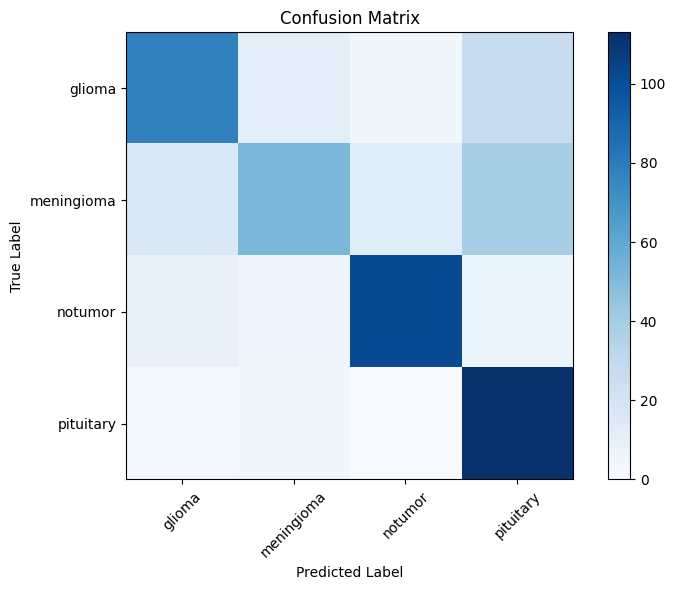


Classification Report:
              precision    recall  f1-score   support

      glioma       0.74      0.65      0.69       120
  meningioma       0.72      0.43      0.54       120
     notumor       0.86      0.84      0.85       120
   pituitary       0.61      0.94      0.74       120

    accuracy                           0.72       480
   macro avg       0.73      0.72      0.71       480
weighted avg       0.73      0.72      0.71       480



In [16]:
test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# test_generator = test_data_generator.flow_from_directory(
#     test_dir,
#     batch_size=32,
#     class_mode='categorical',
#     shuffle=False
# )

# saved_model = tf.keras.models.load_model('model_ckpt.model.keras')

# Evaluate the model on the test data
evaluation = model.evaluate(test_generator, steps=len(test_generator))

# Print evaluation metrics
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

# Get true labels
true_labels = test_generator.classes

# Predict labels
predictions = model.predict(test_generator, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices, rotation=45)
plt.yticks(tick_marks, test_generator.class_indices)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print('\nClassification Report:')
print(classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys()))